In [34]:
import torch
import torch.nn as nn
from sklearn.cluster import DBSCAN
from transformers import AutoTokenizer, AutoModel
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import NearestNeighbors
import os
from sklearn.feature_extraction.text import TfidfVectorizer

In [36]:
import re
import string  

# 텍스트 전처리 함수 정의
def preprocess_text(text):
    if isinstance(text, str):
        return re.sub(r'[^\s\d\w]', '', text)

    return text

# Step 1: Load and preprocess data
with open('products.txt', 'r', encoding='utf-8') as file:
    texts = [preprocess_text(line.strip()) for line in file.readlines()]

# 텍스트 전처리 결과 확인
for i, text in enumerate(texts[:5]):  # 처음 5개의 텍스트만 출력
    print(f"Text {i+1}: {text}")


Text 1: 메티스 미라클워터 과일 야채 세척제 400ml 2개
Text 2: 메티스 미라클워터 과일 야채 세척제 400ml 6개
Text 3: 메티스 미라클워터 의류신발용 탈취제 400ml 2개
Text 4: 메티스 미라클워터 의류신발용 탈취제 400ml 6개
Text 5: 메티스 스탠드 제습제 150g 10개


In [38]:
# Step 2: TF-IDF 벡터화
vectorizer = TfidfVectorizer(max_features=5000)  # 최대 5000개의 특성으로 제한
tfidf_embeddings = vectorizer.fit_transform(texts).toarray()


In [46]:

# DAN 모델 클래스 정의
class DAN(nn.Module):
    def __init__(self, embedding_dim, hidden_dim, output_dim, num_layers, dropout=0.2):
        super(DAN, self).__init__()
        self.embedding_dim = embedding_dim
        self.mlp = nn.Sequential(
            nn.Linear(embedding_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(dropout),
            *[
                nn.Sequential(
                    nn.Linear(hidden_dim, hidden_dim),
                    nn.ReLU(),
                    nn.Dropout(dropout)
                ) for _ in range(num_layers - 1)
            ],
            nn.Linear(hidden_dim, output_dim)
        )

    def forward(self, embeddings):
        output = self.mlp(embeddings)
        return output

# Step 3: DAN 모델 초기화
embedding_dim = 300
hidden_dim = 128
output_dim = 64
num_layers = 3
dan_model = DAN(embedding_dim, hidden_dim, output_dim, num_layers)



In [40]:

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')



In [51]:
import torch
import torch.nn as nn

# RNN 기반 모델 클래스 정의
class RNNModel(nn.Module):
    def __init__(self, embedding_dim, hidden_dim, output_dim, num_layers, dropout=0.2):
        super(RNNModel, self).__init__()
        self.embedding_dim = embedding_dim
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.rnn = nn.RNN(embedding_dim, hidden_dim, num_layers, batch_first=True, dropout=dropout, nonlinearity='relu')
        self.fc = nn.Linear(hidden_dim, output_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, embeddings):
        # RNN에 입력하기 위해 시퀀스 차원을 추가
        embeddings = embeddings.unsqueeze(1)  # [batch_size, seq_len=1, embedding_dim]

        # RNN으로 순차 데이터 처리
        rnn_out, _ = self.rnn(embeddings)
        
        # RNN의 마지막 출력만 사용
        last_output = rnn_out[:, -1, :]  # [batch_size, hidden_dim]

        # 최종 출력 계산
        output = self.dropout(last_output)
        output = self.fc(output)
        return output

# RNN 모델 초기화
embedding_dim = 300
hidden_dim = 128
output_dim = 64
num_layers = 3
rnn_model = RNNModel(embedding_dim, hidden_dim, output_dim, num_layers)

# 모델 사용 예시
rnn_embedding = torch.randn(1, embedding_dim)  # 예시로 임의의 임베딩 사용
output = rnn_model(rnn_embedding)
print(output)


tensor([[-0.0114, -0.0315, -0.1551,  0.0240, -0.2422,  0.0590,  0.0183,  0.1184,
          0.0101,  0.0427,  0.1609,  0.1450,  0.0771,  0.1278, -0.0332, -0.0250,
         -0.0240,  0.0226, -0.1564, -0.2468,  0.0417,  0.0100, -0.0810,  0.0278,
         -0.0997, -0.0668, -0.1941,  0.0189,  0.0574,  0.0910, -0.0006,  0.0299,
          0.1513, -0.0772, -0.0054, -0.0660,  0.0606, -0.0116,  0.0309, -0.1702,
         -0.1194, -0.1577, -0.1602,  0.1152,  0.1092, -0.1339, -0.0335,  0.0355,
          0.0825, -0.0654, -0.2311,  0.1108,  0.0746,  0.1205, -0.0304,  0.0004,
         -0.0151, -0.0387,  0.0251, -0.1127,  0.0376, -0.0432, -0.0197, -0.0797]],
       grad_fn=<AddmmBackward0>)


In [56]:
import torch
import numpy as np
from sklearn.decomposition import TruncatedSVD


svd = TruncatedSVD(n_components=300) 
tfidf_reduced = svd.fit_transform(tfidf_embeddings)  

rnn_model = rnn_model.to(device)

batch_size = 1000  # 배치 크기 설정
rnn_embedding = []

with torch.no_grad():  
    for i in range(0, len(tfidf_reduced), batch_size):
        batch_embeddings = torch.tensor(tfidf_reduced[i:i+batch_size], dtype=torch.float32).to(device)
        batch_output = rnn_model(batch_embeddings).cpu().numpy()
        rnn_embedding.append(batch_output)

# Step 4: 결과 병합
rnn_embeddings = np.vstack(rnn_embedding)

In [47]:
import torch
import numpy as np
from sklearn.decomposition import TruncatedSVD

# Step 1: TruncatedSVD로 차원 축소
svd = TruncatedSVD(n_components=300)  # 차원을 300으로 축소
tfidf_reduced = svd.fit_transform(tfidf_embeddings)  # tfidf_reduced 생성

# Step 2: DAN 모델 정의 및 초기화 (이미 정의된 DAN 모델 사용)

dan_model = dan_model.to(device)


batch_size = 1000  # 배치 크기 설정
dan_embeddings = []

with torch.no_grad():  
    for i in range(0, len(tfidf_reduced), batch_size):
        batch_embeddings = torch.tensor(tfidf_reduced[i:i+batch_size], dtype=torch.float32).to(device)
        batch_output = dan_model(batch_embeddings).cpu().numpy()
        dan_embeddings.append(batch_output)

# Step 4: 결과 병합
dan_embeddings = np.vstack(dan_embeddings)

In [ ]:
# Step 4: PCA로 차원 축소
pca = PCA(n_components=50)  # 차원을 50으로 축소
reduced_embeddings = pca.fit_transform(rnn_embeddings)

from sklearn.mixture import GaussianMixture

# GMM 클러스터링
gmm = GaussianMixture(n_components=5, random_state=42)
gmm_clusters = gmm.fit_predict(reduced_embeddings)

# 결과 출력
for i, (text, cluster) in enumerate(zip(texts, gmm_clusters)):
    print(f"{i+1}: Text: {text}, Cluster: {cluster}")

In [61]:
import numpy as np

# 마지막 배치 패딩
if rnn_embedding[-1].shape[0] != 1000:
    padding = np.zeros((1000 - rnn_embedding[-1].shape[0], 64))  # 0으로 패딩
    rnn_embedding[-1] = np.vstack([rnn_embedding[-1], padding])

# 모든 배치를 결합한 후 PCA 적용
all_embeddings = np.vstack(rnn_embedding)
pca = PCA(n_components=50)
reduced_embeddings = pca.fit_transform(all_embeddings)
print("PCA 적용 완료.")


PCA 적용 완료.


In [58]:
import numpy as np

# 모든 배치의 크기 확인
batch_sizes = [emb.shape for emb in rnn_embedding]

# 각 배치의 크기를 출력하여 확인
print("각 배치의 크기:", batch_sizes)

# 모든 배치가 동일한 크기를 가지는지 확인
if len(set(batch_sizes)) != 1:
    print("배치 크기가 일관되지 않습니다. 패딩 또는 잘라내기를 통해 크기를 일관되게 만드세요.")
else:
    # PCA 적용
    pca = PCA(n_components=50)
    reduced_embeddings = pca.fit_transform(np.vstack(rnn_embedding))
    print("PCA 적용 완료.")


각 배치의 크기: [(1000, 64), (1000, 64), (1000, 64), (1000, 64), (1000, 64), (1000, 64), (1000, 64), (1000, 64), (1000, 64), (1000, 64), (1000, 64), (1000, 64), (1000, 64), (1000, 64), (1000, 64), (1000, 64), (1000, 64), (1000, 64), (1000, 64), (1000, 64), (1000, 64), (1000, 64), (1000, 64), (1000, 64), (1000, 64), (1000, 64), (1000, 64), (1000, 64), (1000, 64), (1000, 64), (1000, 64), (1000, 64), (1000, 64), (1000, 64), (1000, 64), (1000, 64), (1000, 64), (1000, 64), (1000, 64), (1000, 64), (1000, 64), (1000, 64), (1000, 64), (1000, 64), (1000, 64), (1000, 64), (1000, 64), (1000, 64), (1000, 64), (1000, 64), (1000, 64), (1000, 64), (1000, 64), (1000, 64), (1000, 64), (1000, 64), (1000, 64), (1000, 64), (1000, 64), (1000, 64), (1000, 64), (1000, 64), (1000, 64), (1000, 64), (1000, 64), (1000, 64), (1000, 64), (1000, 64), (1000, 64), (1000, 64), (1000, 64), (1000, 64), (1000, 64), (1000, 64), (1000, 64), (1000, 64), (1000, 64), (1000, 64), (1000, 64), (1000, 64), (1000, 64), (1000, 64), (1000

In [64]:
# RNN 임베딩
# pca = PCA(n_components=50)  # 차원을 50으로 축소
# reduced_embeddings = pca.fit_transform(rnn_embedding)

# from sklearn.mixture import GaussianMixture

# GMM 클러스터링
gmm = GaussianMixture(n_components=5, random_state=42)
gmm_clusters = gmm.fit_predict(reduced_embeddings)

clustered_texts = list(zip(texts, gmm_clusters))

clustered_texts.sort(key=lambda x: x[1])

for i, (text, cluster) in enumerate(clustered_texts):
    print(f"{i+1}: Cluster: {cluster}, Text: {text}")


IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



258932: Cluster: 4, Text: 해태htb 강원 평창수 무라벨 500ml 40개
258933: Cluster: 4, Text: 해태htb 골든드랍 나는 오리지널 175ml 60개
258934: Cluster: 4, Text: 해태htb 과일촌 아침에 사과 15l 6개
258935: Cluster: 4, Text: 해태htb 과일촌 아침에 사과 500ml 12개
258936: Cluster: 4, Text: 해태htb 써니텐 블라스트 포도 15l 12개
258937: Cluster: 4, Text: 해태htb 써니텐 블라스트 포도 15l 1개
258938: Cluster: 4, Text: 해태htb 써니텐 블라스트 포도 15l 36개
258939: Cluster: 4, Text: 해태htb 썬키스트 레몬에이드 350ml 1개
258940: Cluster: 4, Text: 해태htb 썬키스트 머스캣 드링크 175ml 60개
258941: Cluster: 4, Text: 해태htb 썬키스트 스파클링 자몽소다 350ml 1개
258942: Cluster: 4, Text: 해태htb 썬키스트 칵테일 블루하와이 340ml 24개
258943: Cluster: 4, Text: 해태htb 영진 구론산 스파클링 오리지날 150ml 40개
258944: Cluster: 4, Text: 해태htb 코코팜 망고코넛 340ml 1개
258945: Cluster: 4, Text: 해태htb 코코팜 망고코넛 340ml 48개
258946: Cluster: 4, Text: 해태htb 코코팜 피치핑크 복숭아 15l 6개
258947: Cluster: 4, Text: 해태htb 코코팜 피치핑크 복숭아 240ml 6개
258948: Cluster: 4, Text: 해태htb 코코팜 피치핑크 복숭아 240ml 90개
258949: Cluster: 4, Text: 해태htb 코코팜 피치핑크 복숭아 340ml 72개
258950: Cluster: 4, Text: 해태htb 코코팜 화이

In [48]:
# Step 4: PCA로 차원 축소
pca = PCA(n_components=50)  # 차원을 50으로 축소
reduced_embeddings = pca.fit_transform(dan_embeddings)

from sklearn.mixture import GaussianMixture

# GMM 클러스터링
gmm = GaussianMixture(n_components=5, random_state=42)
gmm_clusters = gmm.fit_predict(reduced_embeddings)

# 결과 출력
for i, (text, cluster) in enumerate(zip(texts, gmm_clusters)):
    print(f"{i+1}: Text: {text}, Cluster: {cluster}")

IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)




267149: Text: huyfong푸드 스리라차 핫칠리 소스 482g 4개, Cluster: 2
267150: Text: thomy 토미 홀랜다이즈 소스 250ml 12개, Cluster: 3
267151: Text: thomy 토미 홀랜다이즈 소스 250ml 1개, Cluster: 4
267152: Text: 르네디종 홀그레인 머스타드 190g 12개, Cluster: 4
267153: Text: 르네디종 홀그레인 머스타드 190g 1개, Cluster: 3
267154: Text: 르네디종 홀그레인 머스타드 190g 3개, Cluster: 3
267155: Text: 난도스 페리페리 소스 미디움 250g 2개, Cluster: 3
267156: Text: 난도스 페리페리 소스 미디움 250g 3개, Cluster: 4
267157: Text: 롱고바디 포모도리 필라티 400g 1개, Cluster: 2
267158: Text: 롱고바디 포모도리 필라티 400g 3개, Cluster: 3
267159: Text: 롱고바디 포모도리 필라티 토마토 홀 255kg 1개, Cluster: 3
267160: Text: 롱고바디 포모도리 필라티 토마토 홀 255kg 3개, Cluster: 3
267161: Text: 롱고바디 포모도리 필라티 토마토 홀 255kg 6개, Cluster: 4
267162: Text: 마라판다 마라상궈 소스 1kg 1개, Cluster: 0
267163: Text: 마라판다 마라상궈 소스 1kg 2개, Cluster: 2
267164: Text: 무띠 토마토 홀 25kg 1개, Cluster: 3
267165: Text: 무띠 토마토 홀 25kg 6개, Cluster: 4
267166: Text: 미르마로푸드시스템 맘스맘 흑임자드레싱 2kg 1개, Cluster: 4
267167: Text: 미르마로푸드시스템 맘스맘 흑임자드레싱 2kg 2개, Cluster: 2
267168: Text: 미르마로푸드시스템 맘스맘 흑임자드레싱 2kg 3개

In [18]:
from sklearn.decomposition import PCA
from sklearn.cluster import DBSCAN

# Step 4: PCA로 차원 축소
pca = PCA(n_components=50)  # 차원을 50으로 축소
reduced_embeddings = pca.fit_transform(dan_embeddings)

/tmp/ipykernel_95540/4066514966.py:10: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(reduced_embeddings_2d[:, 0], reduced_embeddings_2d[:, 1], s=30, cmap='viridis')


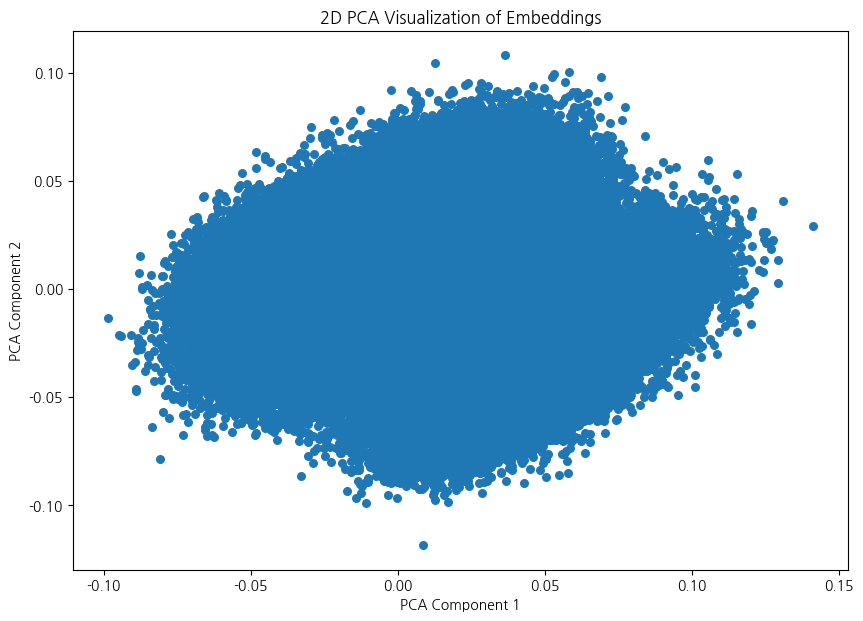

In [49]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# PCA로 2차원으로 축소
pca_2d = PCA(n_components=2)
reduced_embeddings_2d = pca_2d.fit_transform(dan_embeddings)

# 시각화
plt.figure(figsize=(10, 7))
plt.scatter(reduced_embeddings_2d[:, 0], reduced_embeddings_2d[:, 1], s=30, cmap='viridis')
plt.title('2D PCA Visualization of Embeddings')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.show()


In [21]:
from sklearn.mixture import GaussianMixture

gmm = GaussianMixture(n_components=5, random_state=42)
gmm_clusters = gmm.fit_predict(reduced_embeddings)

for i, (text, cluster) in enumerate(zip(texts, gmm_clusters)):
    print(f"{i+1}: Text: {text}, Cluster: {cluster}")


IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



274276: Text: 닥터디퍼런트 비타리프트a 20g 2개, Cluster: 0
274277: Text: 닥터딥 아토딥 비누 100g 10개, Cluster: 4
274278: Text: 닥터딥 아토딥 비누 100g 1개, Cluster: 4
274279: Text: 닥터딥 아토딥 비누 100g 3개, Cluster: 4
274280: Text: 닥터메디오 베베맘맘 깨끗한 엠보싱 아기 물티슈 캡형 100매 10팩, Cluster: 1
274281: Text: 닥터메디오 베베맘맘 깨끗한 엠보싱 아기 물티슈 캡형 100매 20팩, Cluster: 4
274282: Text: 닥터슈라멕 블레미쉬 밤 30ml 1개, Cluster: 1
274283: Text: 닥터슈라멕 블레미쉬 밤 30ml 2개, Cluster: 1
274284: Text: 닥터슈라멕 블레미쉬 밤 30ml 3개, Cluster: 1
274285: Text: 닥터슈라멕 블레미쉬 밤 30ml 4개, Cluster: 1
274286: Text: 닥터슈라멕 블레미쉬 밤 30ml 6개, Cluster: 1
274287: Text: 닥터스필러 티모비트 e 크림 50ml 1개, Cluster: 1
274288: Text: 닥터스필러 티모비트 e 크림 50ml 2개, Cluster: 1
274289: Text: 닥터스필러 티모비트 e 크림 50ml 2개5ml 1개, Cluster: 1
274290: Text: 닥터스필러 티모비트 e 크림 50ml 3개, Cluster: 1
274291: Text: 닥터스필러 티모비트 e 크림 50ml 4개, Cluster: 4
274292: Text: 닥터시스 닥터시스 칼리아 리뉴 클렌저 110ml 1개, Cluster: 4
274293: Text: 닥터시스 닥터시스 칼리아 리뉴 클렌저 110ml 2개, Cluster: 4
274294: Text: 닥터앨스크발드 어마무시 스킨토너 수부지성용 200ml 1개, Cluster: 4
274295: Text: 닥터앨스크발드 어마무시 

In [ ]:
# Step 5: DBSCAN 클러스터링
def cluster_embeddings(embeddings, eps, min_samples):
    dbscan = DBSCAN(eps=eps, min_samples=min_samples, metric='cosine', n_jobs=-1)
    clusters = dbscan.fit_predict(embeddings)
    return clusters

eps = 0.5
min_samples = 1
clusters = cluster_embeddings(reduced_embeddings, eps, min_samples)

In [10]:
# Step 5: 결과 출력
for i, (text, cluster) in enumerate(zip(texts, clusters)):
    print(f"{i+1}: Text: {text}, Cluster: {cluster}")


1: Text: 메티스 미라클워터 과일 야채 세척제 400ml 2개, Cluster: 0
2: Text: 메티스 미라클워터 과일 야채 세척제 400ml 6개, Cluster: 0
3: Text: 메티스 미라클워터 의류신발용 탈취제 400ml 2개, Cluster: 0
4: Text: 메티스 미라클워터 의류신발용 탈취제 400ml 6개, Cluster: 0
5: Text: 메티스 스탠드 제습제 150g 10개, Cluster: 0
6: Text: 메티스 스탠드 제습제 150g 50개, Cluster: 0
7: Text: 메티스 습기 담는 입큰 개구리 250g 20개, Cluster: 0
8: Text: 메티스 습기 담는 입큰 개구리 250g 30개, Cluster: 0
9: Text: 메티스 옷걸이 제습제 150g 10개, Cluster: 0
10: Text: 메티스 옷걸이 제습제 150g 30개, Cluster: 0
11: Text: 메티스 옷걸이 제습제 150g 50개, Cluster: 0
12: Text: lg전자 15n530ut50k 750gb, Cluster: 0
13: Text: lg전자 15n530ut50k msata 128gb, Cluster: 0
14: Text: lg전자 15nd540ux50k 1tb, Cluster: 0
15: Text: lg전자 15nd540ux50k ssd 120gb  1tb, Cluster: 0
16: Text: lg전자 15nd540ux50k ssd 250gb  1tb, Cluster: 0
17: Text: lg전자 15nd540ux50k ssd 500gb  1tb, Cluster: 0
18: Text: lg전자 15z90rnapc3u1 해외 리퍼비시 ssd 1tb, Cluster: 0
19: Text: lg전자 15z90rnapc3u1 해외 리퍼비시 ssd 256gb, Cluster: 0
20: Text: lg전자 15z90rnapc3u1 해외 리퍼비시 ssd 2tb, Cluster: 0
21: Text: lg전자 1

IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



273040: Text: 제이펜즈 marvy 패브릭마커 세트 10색, Cluster: 0
273041: Text: 제이펜즈 marvy 패브릭마커 세트 6색, Cluster: 0
273042: Text: 조소냐 조선자 아크릴 과슈 75ml 낱색 시리즈2, Cluster: 0
273043: Text: 조소냐 조선자 아크릴 과슈 75ml 낱색 시리즈3, Cluster: 0
273044: Text: 주영상사 1000 하트 지우개 연필깎이 1개, Cluster: 0
273045: Text: 주영상사 1000 하트 지우개 연필깎이 24개, Cluster: 0
273046: Text: 지구화학 투명이 낱색 색연필 12개, Cluster: 0
273047: Text: 지구화학 투명이 낱색 색연필 1개, Cluster: 0
273048: Text: 칠성당 인황 면상필 1호, Cluster: 0
273049: Text: 칠성당 인황 면상필 5호, Cluster: 0
273050: Text: 칠성당 인황 면상필 7호, Cluster: 0
273051: Text: 카웨코 알 스포츠 스톤워시 볼펜 블랙, Cluster: 0
273052: Text: 카웨코 알 스포츠 스톤워시 볼펜 블루, Cluster: 0
273053: Text: 쿠레타케 지그 지그 리얼브러쉬 rb6000at 12색, Cluster: 0
273054: Text: 쿠레타케 지그 지그 리얼브러쉬 rb6000at 1개, Cluster: 0
273055: Text: 쿠레타케 지그 지그 리얼브러쉬 rb6000at 24색, Cluster: 0
273056: Text: 쿠레타케 지그 지그 리얼브러쉬 rb6000at 36색, Cluster: 0
273057: Text: 크레욜라 일반크레용 120색, Cluster: 0
273058: Text: 크레욜라 일반크레용 152색, Cluster: 0
273059: Text: 크레욜라 일반크레용 16색, Cluster: 0
273060: Text: 크레욜라 일반크레용 24색, Cluster

In [11]:
num_clusters = len(set(clusters)) - (1 if -1 in clusters else 0)
print(f'클러스터 수: {num_clusters}')

클러스터 수: 1
